In [1]:
from shapesynthesis.loaders import load_model, load_config

config, _ = load_config("../configs/encoder_128_airplane.yaml")

# config
model = load_model(config.modelconfig,"../trained_models/encoder_128_airplane.ckpt")

Warp CUDA error 100: no CUDA-capable device is detected (in function init_cuda_driver, /builds/omniverse/warp/warp/native/cuda_util.cpp:240)
Warp CUDA error 3: initialization error (in function cuda_device_get_count, /builds/omniverse/warp/warp/native/warp.cu:1685)


Warp 1.5.0 initialized:
   CUDA devices not available
   Devices:
     "cpu"      : "x86_64"
   Kernel cache:
     /home/ernst/.cache/warp/1.5.0


tensor(-0.0002) tensor(1.) torch.Size([500, 128, 128])
tensor([[ 5.6434e-04, -1.0252e-05,  6.1738e-04,  ...,  1.1287e-03,
          1.1322e-03,  2.0970e-03],
        [ 2.4509e-04,  9.2542e-04,  1.3965e-03,  ...,  1.8405e-03,
          4.7386e-04,  1.2321e-03],
        [ 1.9133e-04,  1.3851e-03,  1.4853e-03,  ...,  2.1514e-03,
          1.3366e-03,  1.4565e-03],
        ...,
        [ 9.9959e-01,  1.0000e+00,  9.9976e-01,  ...,  9.9971e-01,
          9.9962e-01,  9.9889e-01],
        [ 1.0000e+00,  1.0000e+00,  9.9971e-01,  ...,  9.9987e-01,
          9.9947e-01,  9.9938e-01],
        [ 9.9987e-01,  1.0000e+00,  9.9898e-01,  ...,  9.9963e-01,
          9.9946e-01,  9.9870e-01]])


/tmp/ipykernel_42481/2853158461.py:3: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  ects = torch.load("../generated_ects.pt")


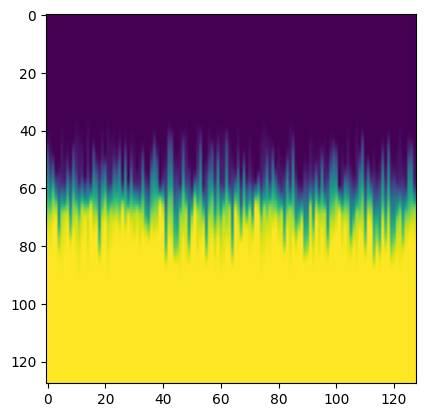

In [4]:
import torch 
import matplotlib.pyplot as plt
ects = torch.load("../generated_ects.pt")


print(ects[0].min(),ects[0].max(),ects.shape)

plt.imshow(ects[0].squeeze())

print(ects[0])



In [24]:
with torch.no_grad():
    pts = model.model(ects).view(-1,2048,3).cpu()

pts.shape

torch.Size([500, 2048, 3])

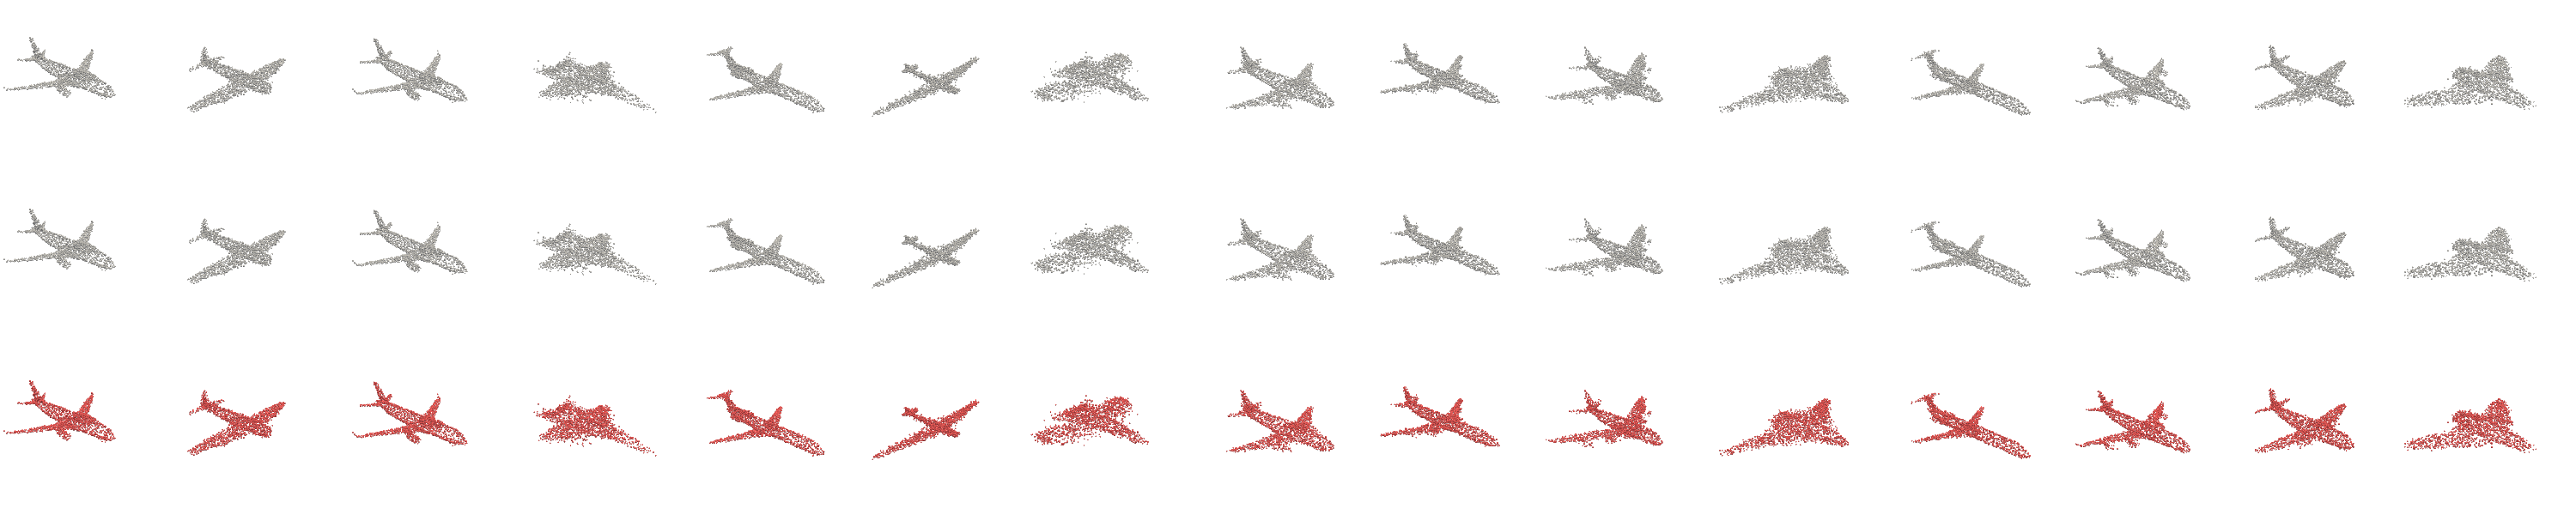

In [25]:
from plotting import plot_recon_3d
plot_recon_3d(recon_pcs=pts.numpy(),ref_pcs=pts.numpy(),num_pc=15,offset=100)


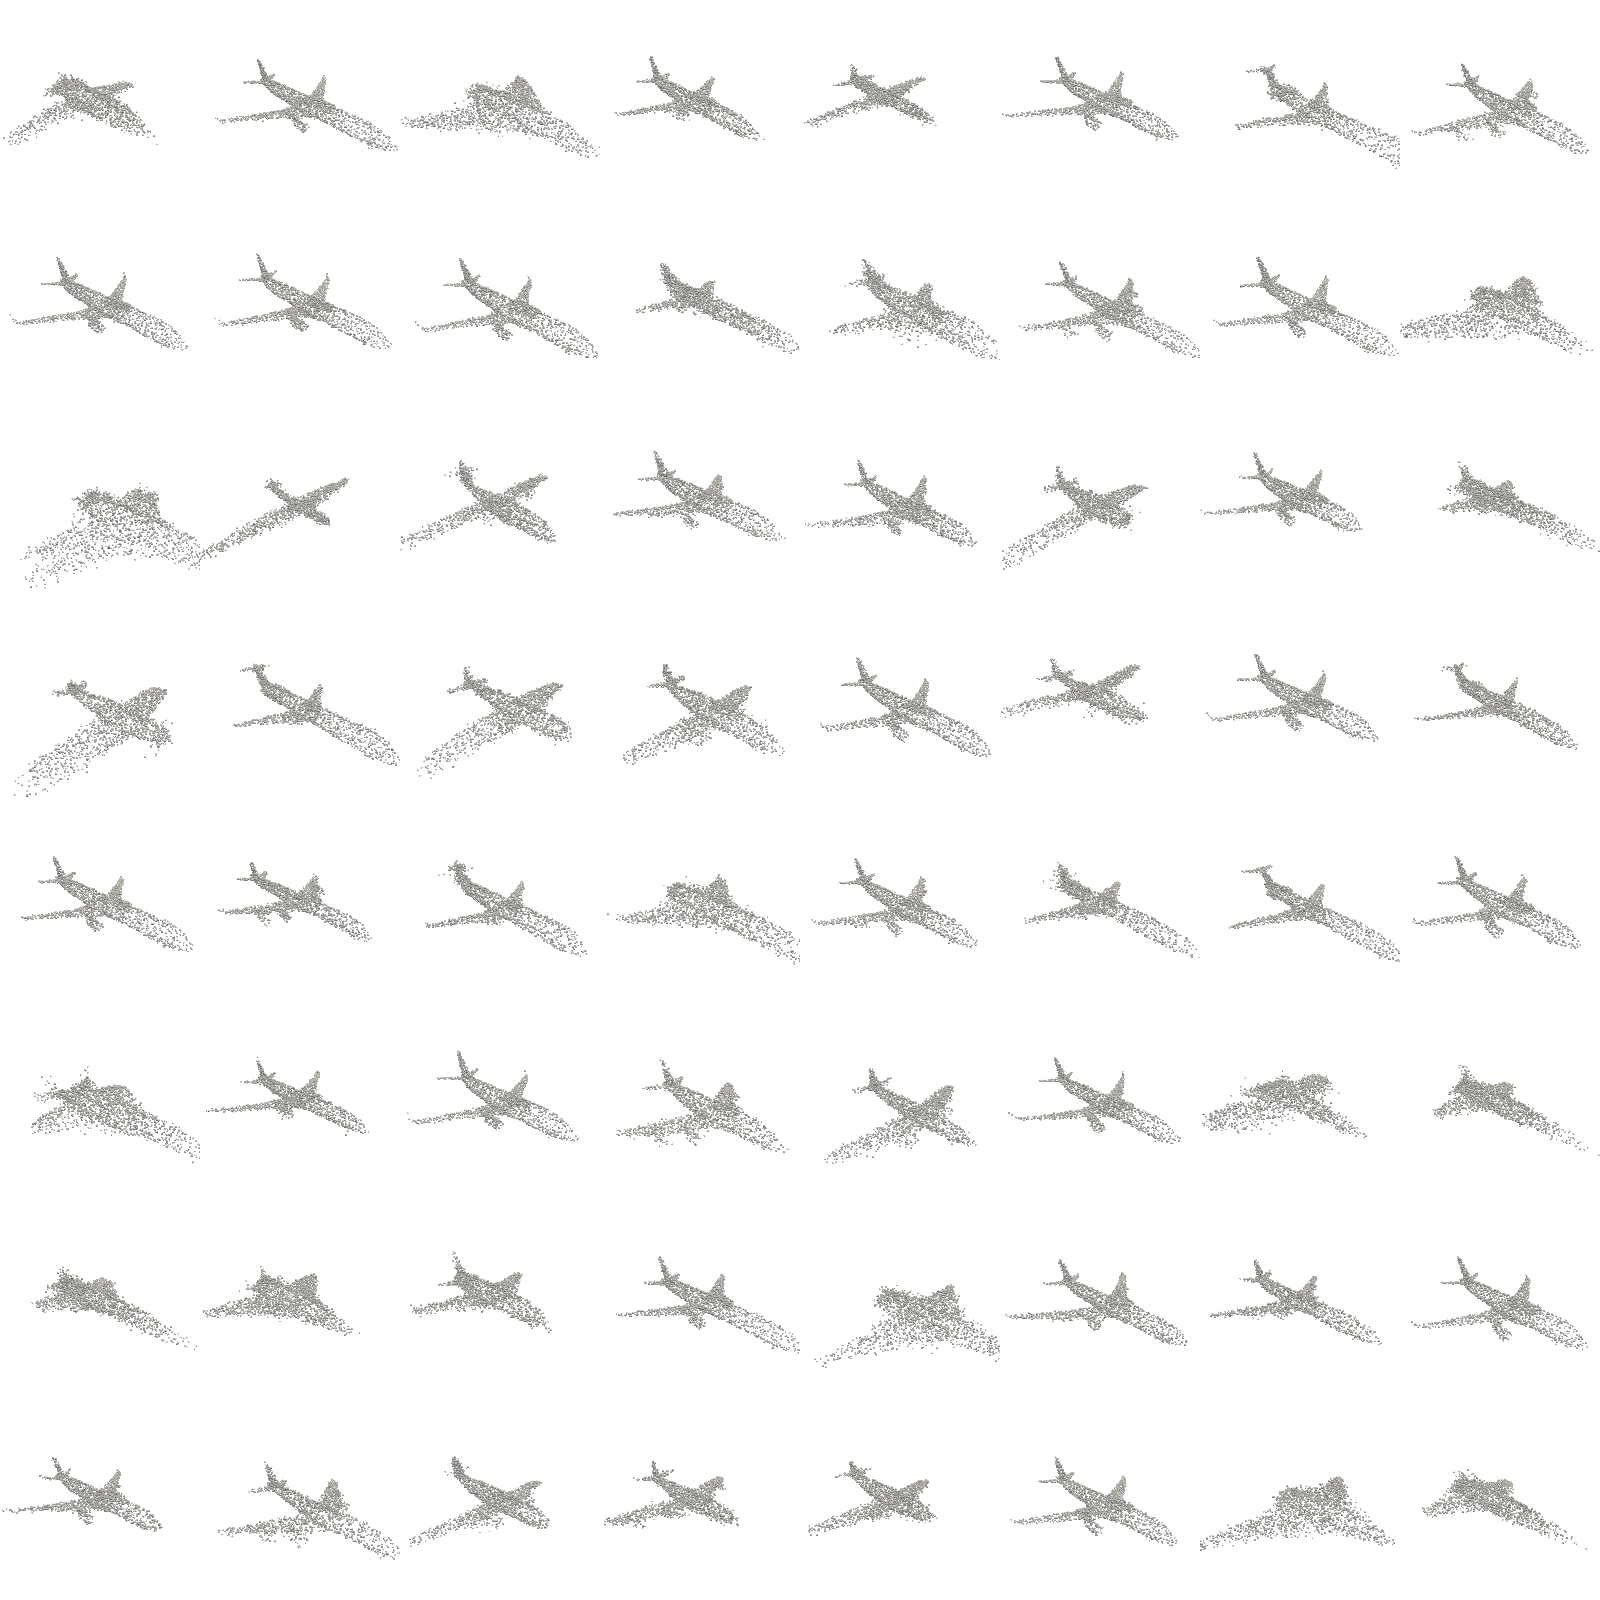

In [26]:
import pyvista as pv

pl = pv.Plotter(
        shape=(8, 8),
        window_size=[1600, 1600],
        border=False,
        polygon_smoothing=True,
    )

for col in range(8):
    for row in range(8):
        # First plat
        pl.subplot(row, col)
        actor = pl.add_points(
            pts[2*(col * 8 + row)].numpy(),
            style="points",
            emissive=False,
            show_scalar_bar=False,
            render_points_as_spheres=True,
            color="lightgray",
            point_size=2,
            ambient=0.2,
            diffuse=0.8,
            specular=0.8,
            specular_power=40,
            smooth_shading=True,
        )
        
pl.background_color = "w"
pl.link_views()
pl.camera_position = "xy"
pos = pl.camera.position
pl.camera.position = (pos[0], pos[1] + 3, pos[2])
pl.camera.position = (5, 0, 0)
pl.camera.azimuth = 45
pl.camera.elevation = 30
# create a top down light
light = pv.Light(
    position=(0, 0, 0), positional=True, cone_angle=50, exponent=20, intensity=0.2
)
pl.add_light(light)
pl.camera.zoom(.4)
pl.show()

In [29]:
from shapesynthesis.metrics.evaluation import compute_all_metrics

airplane_refs = torch.load("../results/vae_airplane_latent/references.pt").cpu()
s = torch.load("../results/vae_airplane_latent/stdevs.pt").cpu()
m = torch.load("../results/vae_airplane_latent/means.pt").cpu()

pts = pts[:405] * s + m

print(s.shape,m.shape)





torch.Size([405, 1, 1]) torch.Size([405, 1, 3])


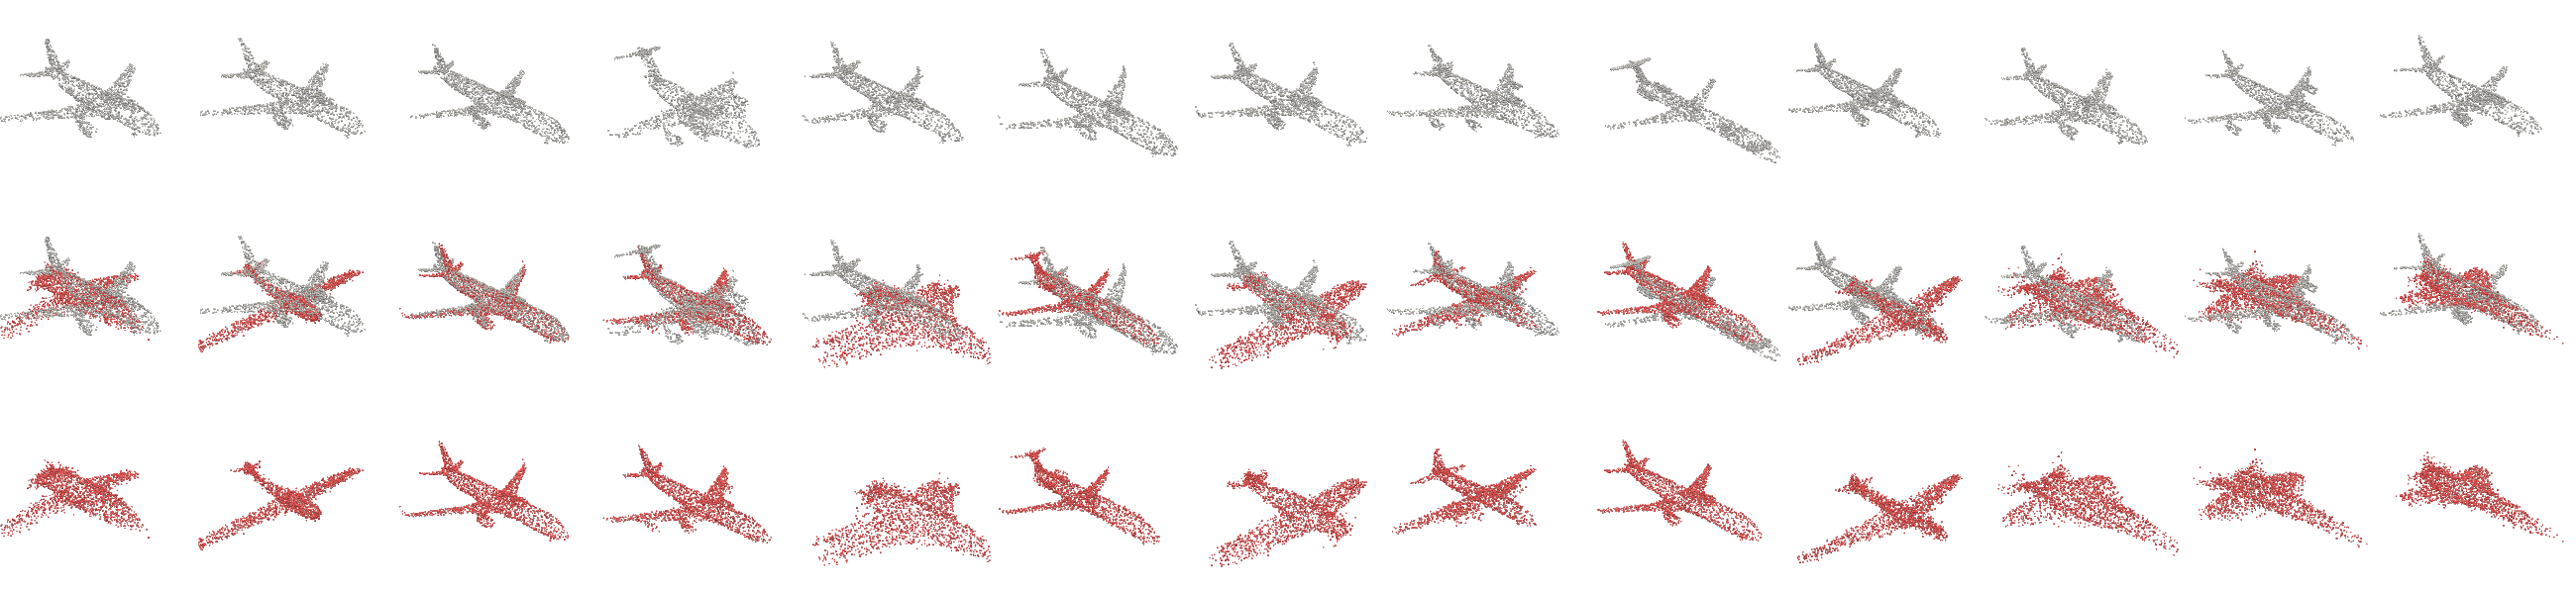

In [32]:
from plotting import plot_recon_3d


plot_recon_3d(airplane_refs.cpu().numpy()*10,pts.numpy()*10,num_pc=13)

In [34]:
compute_all_metrics(pts,airplane_refs,batch_size=100)

100%|██████████| 405/405 [04:06<00:00,  1.65it/s]


{'lgan_mmd-CD': tensor(0.0002),
 'lgan_cov-CD': tensor(0.4667),
 'lgan_mmd_smp-CD': tensor(0.0005),
 'lgan_mmd-EMD': tensor(0.0035),
 'lgan_cov-EMD': tensor(0.4568),
 'lgan_mmd_smp-EMD': tensor(0.0061),
 '1-NN-CD-acc_t': tensor(0.6469),
 '1-NN-CD-acc_f': tensor(0.9062),
 '1-NN-CD-acc': tensor(0.7765),
 '1-NN-EMD-acc_t': tensor(0.5926),
 '1-NN-EMD-acc_f': tensor(0.7852),
 '1-NN-EMD-acc': tensor(0.6889)}